In [1]:
from lxml import etree
import copy
import xml.etree.ElementTree as ET


In [2]:
# Function to create a robot element
def create_robot_element():
    robot = etree.Element("robot", name="simple_robot")
    return robot

# Function to create a geometry element
def create_geometry_element(shape, **kwargs):
    geometry = etree.Element("geometry")
    shape_elem = etree.Element(shape)
    if shape == "box":
        shape_elem.set("size", kwargs.get("size", "1 1 1"))
    elif shape == "cylinder":
        shape_elem.set("radius", kwargs.get("radius", "1"))
        shape_elem.set("length", kwargs.get("length", "1"))
    elif shape == "sphere":
        shape_elem.set("radius", kwargs.get("radius", "1"))
    elif shape == "mesh":
        shape_elem.set("filename", kwargs.get("filename", "mesh.stl"))
    geometry.append(shape_elem)
    return geometry

# Function to create a visual element
def create_visual_element(geometry, origin_xyz="0 0 0", origin_rpy="0 0 0", color_rgba="0.5 0.5 0.5 1.0"):
    visual = etree.Element("visual")
    origin = etree.Element("origin", xyz=origin_xyz, rpy=origin_rpy)
    visual.append(origin)
    visual.append(geometry)
    material = etree.Element("material")
    color = etree.Element("color", rgba=color_rgba)
    material.append(color)
    visual.append(material)
    return visual

# Function to create a collision element
def create_collision_element(geometry, origin_xyz="0 0 0", origin_rpy="0 0 0"):
    collision = etree.Element("collision")
    origin = etree.Element("origin", xyz=origin_xyz, rpy=origin_rpy)
    collision.append(origin)
    collision.append(geometry)
    return collision

# Function to create a link element
def create_link_element(name, geometry, origin_xyz="0 0 0", origin_rpy="0 0 0", inertial_mass="1.0", inertial_inertia="1.0 1.0 1.0 0 0 0"):
    link = etree.Element("link", name=name)
    
    # Adding inertial
    inertial = etree.Element("inertial")
    mass = etree.Element("mass", value=inertial_mass)
    inertia = etree.Element("inertia", ixx=inertial_inertia.split()[0], ixy=inertial_inertia.split()[1], ixz=inertial_inertia.split()[2],
                            iyy=inertial_inertia.split()[3], iyz=inertial_inertia.split()[4], izz=inertial_inertia.split()[5])
    inertial.append(mass)
    inertial.append(inertia)
    link.append(inertial)
    
    # Adding visual
    visual = create_visual_element(geometry, origin_xyz, origin_rpy)
    link.append(visual)
    
    # Adding collision
    collision = create_collision_element(geometry, origin_xyz, origin_rpy)
    link.append(collision)
    
    return link

# Function to create a joint element
def create_joint_element(name, joint_type="fixed", parent="link1", child="link2", origin_xyz="0 0 0", origin_rpy="0 0 0"):
    joint = etree.Element("joint", name=name, type=joint_type)
    
    # Adding origin
    origin = etree.Element("origin", xyz=origin_xyz, rpy=origin_rpy)
    joint.append(origin)
    
    # Adding parent
    parent_elem = etree.Element("parent", link=parent)
    joint.append(parent_elem)
    
    # Adding child
    child_elem = etree.Element("child", link=child)
    joint.append(child_elem)
    
    return joint

# Main function to create and save URDF
def create_urdf():
    # Create robot element
    robot = create_robot_element()
    
    # Define geometry for links
    box_geometry = create_geometry_element("box", size="1 1 1")
    cylinder_geometry = create_geometry_element("cylinder", radius="0.5", length="1")
    
    # Create and append links
    link1 = create_link_element(name="link1", geometry=box_geometry)
    link2 = create_link_element(name="link2", geometry=cylinder_geometry)
    robot.append(link1)
    robot.append(link2)
    
    # Create and append joint
    joint = create_joint_element(name="joint1")
    robot.append(joint)
    
    # Create ElementTree object
    tree = etree.ElementTree(robot)
    
    # Write to file with XML declaration
    with open("simple_robot.urdf", "wb") as file:
        tree.write(file, pretty_print=True, xml_declaration=True, encoding="UTF-8")
    
    print("URDF file created successfully with XML declaration.")





In [7]:
# Eseguire la funzione per creare l'URDF
create_urdf()

URDF file created successfully with XML declaration.


get inertial from pointcloud

In [6]:
import numpy as np
from scipy.spatial import ConvexHull

def compute_inertia_tensor(points, mass=1.0):
    """
    Compute the inertia tensor of a point cloud representing an irregular shape.

    Args:
    - points (np.ndarray): An (N, 3) array of points.
    - mass (float): Total mass of the shape.

    Returns:
    - inertia_tensor (np.ndarray): A (3, 3) inertia tensor matrix.
    """
    hull = ConvexHull(points)
    volume = hull.volume
    density = mass / volume

    # Centroid of the hull
    centroid = np.mean(points[hull.vertices], axis=0)

    # Translate points to the centroid
    points_centered = points - centroid

    # Initialize the inertia tensor
    inertia_tensor = np.zeros((3, 3))

    # Compute the inertia tensor
    for simplex in hull.simplices:
        vertices = points[simplex]
        v0, v1, v2 = vertices
        tetra_volume = np.abs(np.dot(v0 - v2, np.cross(v1 - v2, v2 - centroid))) / 6.0
        tetra_mass = density * tetra_volume

        for i in range(3):
            for j in range(3):
                if i == j:
                    inertia_tensor[i, j] += tetra_mass * (
                        np.sum(vertices[:, (i + 1) % 3]**2 + vertices[:, (i + 2) % 3]**2)
                        - np.sum(vertices[:, i])**2
                    ) / 10.0
                else:
                    inertia_tensor[i, j] -= tetra_mass * np.sum(vertices[:, i] * vertices[:, j]) / 10.0

    return inertia_tensor

# Example usage
points = np.array([
    [0.5, 0.5, 0.5],
    [0.5, -0.5, 0.5],
    [-0.5, -0.5, 0.5],
    [-0.5, 0.5, 0.5],
    [0.5, 0.5, -0.5],
    [0.5, -0.5, -0.5],
    [-0.5, -0.5, -0.5],
    [-0.5, 0.5, -0.5]
])
inertia_tensor = compute_inertia_tensor(points, mass=1.0)
print("Inertia Tensor:\n", inertia_tensor)


Inertia Tensor:
 [[ 5.83333333e-02  8.67361738e-19 -8.33333333e-03]
 [ 8.67361738e-19  5.83333333e-02 -8.33333333e-03]
 [-8.33333333e-03 -8.33333333e-03  5.83333333e-02]]


```xml
<inertial>
  <mass value="1.0"/> <!-- Specify the mass of the link -->
  <origin xyz="0 0 0" rpy="0 0 0"/> <!-- Origin of the inertial frame relative to the link frame -->
  
  <!-- Inertia tensor defined using the elements Ixx, Iyy, Izz, Ixy, Ixz, Iyz -->
  <inertia ixx="0.058333333" iyy="0.058333333" izz="0.058333333"
           ixy="0.0" ixz="-0.008333333" iyz="-0.008333333"/>
</inertial>

```

specifically for fruits

In [8]:
import numpy as np

def sphere_inertia_tensor(mass, diameter):
    """
    Calculate the inertia tensor for a sphere given its mass and diameter.
    
    Args:
    - mass: Mass of the sphere in kilograms.
    - diameter: Diameter of the sphere in meters.
    
    Returns:
    - Numpy array representing the inertia tensor [Ixx, Iyy, Izz].
    """
    # Convert diameter to radius
    radius = diameter / 2.0
    
    # Calculate moment of inertia for a solid sphere
    I = (2/5) * mass * radius**2
    
    # Inertia tensor for a sphere (Ixx, Iyy, Izz are equal)
    Ixx = I
    Iyy = I
    Izz = I
    
    # Return as a numpy array
    return np.array([[Ixx, 0, 0],
                     [0, Iyy, 0],
                     [0, 0, Izz]])

# Given parameters
mass = 0.190  # mass in kg (190 grams)
diameter = 0.070  # diameter in meters (70 mm)

# Calculate the inertia tensor
inertia_tensor = sphere_inertia_tensor(mass, diameter)

print("Inertia Tensor:")
print(inertia_tensor)


Inertia Tensor:
[[9.31e-05 0.00e+00 0.00e+00]
 [0.00e+00 9.31e-05 0.00e+00]
 [0.00e+00 0.00e+00 9.31e-05]]


In [9]:
def inertia_tensor_to_xml(inertia_tensor):
    """
    Convert the inertia tensor into an XML <inertial> tag format for URDF.
    
    Args:
    - inertia_tensor: Numpy array representing the inertia tensor [Ixx, Iyy, Izz].
    
    Returns:
    - String containing the XML <inertial> tag.
    """
    Ixx, Iyy, Izz = inertia_tensor[0, 0], inertia_tensor[1, 1], inertia_tensor[2, 2]
    Ixy, Ixz, Iyz = 0.0, 0.0, 0.0  # Assuming no off-diagonal elements for simplicity
    
    xml_string = f"""
<inertial>
  <mass value="{mass}"/> <!-- Specify the mass of the sphere -->
  <origin xyz="0 0 0" rpy="0 0 0"/> <!-- Origin of the inertial frame relative to the link frame -->
  
  <!-- Inertia tensor defined using the elements Ixx, Iyy, Izz, Ixy, Ixz, Iyz -->
  <inertia ixx="{Ixx:.9f}" iyy="{Iyy:.9f}" izz="{Izz:.9f}"
           ixy="{Ixy:.9f}" ixz="{Ixz:.9f}" iyz="{Iyz:.9f}"/>
</inertial>
"""
    return xml_string

# Example usage
xml_inertial_tag = inertia_tensor_to_xml(inertia_tensor)
print("XML Inertial Tag:")
print(xml_inertial_tag)


XML Inertial Tag:

<inertial>
  <mass value="0.19"/> <!-- Specify the mass of the sphere -->
  <origin xyz="0 0 0" rpy="0 0 0"/> <!-- Origin of the inertial frame relative to the link frame -->
  
  <!-- Inertia tensor defined using the elements Ixx, Iyy, Izz, Ixy, Ixz, Iyz -->
  <inertia ixx="0.000093100" iyy="0.000093100" izz="0.000093100"
           ixy="0.000000000" ixz="0.000000000" iyz="0.000000000"/>
</inertial>



# `.world`

In [2]:
from lxml import etree

def create_empty_world(world_name='name', lon=None, lat=None):
    # Create the root element with tag 'sdf' and attribute version='1.6'
    root = etree.Element("sdf", version='1.6')
    
    # Create the 'world' sub-element
    world = etree.SubElement(root, 'world', name=world_name)

    # List of XML fragments to be appended
    xml_strings = [
        """
        <light name='sun' type='directional'>
            <cast_shadows>1</cast_shadows>
            <pose frame=''>0 0 10 0 -0 0</pose>
            <diffuse>1 1 1 1</diffuse>
            <specular>0.2 0.2 0.2 1</specular>
            <attenuation>
                <range>1000</range>
                <constant>0.9</constant>
                <linear>0.01</linear>
                <quadratic>0.001</quadratic>
            </attenuation>
            <direction>-0.5 -0.5 -1</direction>
        </light>
        """,
        """
        <physics name='default_physics' default='0' type='ode'>
            <max_step_size>0.001</max_step_size>
            <real_time_factor>1</real_time_factor>
            <real_time_update_rate>1000</real_time_update_rate>
        </physics>
        """,
        """ 
        <scene>
            <ambient>1 1 1 1</ambient>
            <background>0.2 0.5 0.7 1</background>
            <shadows>1</shadows>
        </scene>
        """,
        f""" 
        <spherical_coordinates>
            <surface_model>EARTH_WGS84</surface_model>
            <latitude_deg>{lat}</latitude_deg>
            <longitude_deg>{lon}</longitude_deg>
            <elevation>0</elevation>
            <heading_deg>0</heading_deg>
        </spherical_coordinates>
        """,
        """ 
        <state world_name='default'>
            <sim_time>203 490000000</sim_time>
            <real_time>168 470627290</real_time>
            <wall_time>1596490486 155571625</wall_time>
            <iterations>167975</iterations>
            <light name='sun'>
                <pose frame=''>0 0 10 0 -0 0</pose>
            </light>
        </state>
        """,
        """
        <gravity>0 0 -9.8</gravity>
        """,
        """
        <magnetic_field>6e-06 2.3e-05 -4.2e-05</magnetic_field>
        """,
        """
        <atmosphere type='adiabatic'/>
        """
    ]

    # Append each XML fragment to the 'world' element
    for xml_string in xml_strings:
        world.append(etree.fromstring(xml_string))

    return root

In [58]:
def create_xml_state_model(objID, posX, posY, posZ, heading_rad):
  return f"""
          <model name='{objID}'>
            <pose frame=''>0 0 0 0 0 0</pose>
            <scale>1 1 1</scale>
            <link name='{objID}_link'>
              <!-- TO MODIFY THE POSITION OF THE OBJ ON THE LOCAL MAP USE THIS POSE -->
              <pose frame=''> {posX} {posY} {posZ} 0 0 -{heading_rad}</pose>
              <velocity>0 0 0 0 0 0</velocity>
              <acceleration>0 0 0 0 0 0</acceleration>
              <wrench>0 0 0 0 -0 0</wrench>
            </link>
          </model>"""

In [ ]:
# object find the key the use model item
meshes_collection = {
    'PL-15' : '//vegetation/meshes/planar_tree/planar_tree.dae',
    'PL-20' : '//vegetation/meshes/planar_tree/planar_tree.dae',
    'apple' : '//apple/meshes/apple_1mm.dae'    
}

In [70]:
def create_xml_planar_tree_model(objID):
    return f"""
            <model name='{objID}'>
                <link name='{objID}_link'>
                    <pose frame=''>0 0 0 0 -0 0</pose>
                    <inertial>
                    <pose frame=''>0 0 0 0 -0 0</pose>
                    <mass>50</mass>
                    <inertia>
                        <ixx>1000</ixx>
                        <ixy>1000</ixy>
                        <ixz>1000</ixz>
                        <iyy>1000</iyy>
                        <iyz>1000</iyz>
                        <izz>1000</izz>
                    </inertia>
                    </inertial>
                    <collision name='{objID}_link_collision'>
                    <pose frame=''>0 0 0 0 -0 0</pose>
                    <geometry>
                        <mesh>
                        <scale>1 1 1</scale>
                        <uri>model://vegetation/meshes/planar_tree/planar_tree.dae</uri>
                        </mesh>
                    </geometry>
                    <max_contacts>10</max_contacts>
                    <surface>
                        <contact>
                        <ode/>
                        </contact>
                        <bounce/>
                        <friction>
                        <torsional>
                            <ode/>
                        </torsional>
                        <ode/>
                        </friction>
                    </surface>
                    </collision>
                    <visual name='{objID}_link_visual'>
                    <pose frame=''>0 0 0 0 -0 0</pose>
                    <geometry>
                        <mesh>
                        <scale>1 1 1</scale>
                        <uri>model://vegetation/meshes/planar_tree/planar_tree.dae</uri>
                        </mesh>
                    </geometry>
                    </visual>
                    <self_collide>0</self_collide>
                    <enable_wind>0</enable_wind>
                    <kinematic>0</kinematic>
                </link>
                <static>1</static>
                <pose frame=''>0 0 0 0 -0 0</pose>
            </model>
            """

In [64]:
# Create a new root element
root = create_empty_world(world_name='cadriano', lon=11.413247162541492, lat=44.5490768361046  )
# print(root)


# Find the 'state' tag
state = root.find('.//state')
model = root.find('world')

# Iterate over the characters and their indices
for i, char in enumerate(['PL-15_1_1', 'PL-15_1_2', 'PL-15_1_3']):
    # Create a new XML model string
    new_state_model_string = create_xml_state_model(char, i*2, i,0)
    
    # Parse the new XML model string into an Element
    new_state_model_element = etree.fromstring(new_state_model_string)
   
    # Add the new model element to the root element
    state.append(new_state_model_element)

    # new model
    model_str = create_xml_planar_tree_model(char)
    model_element = etree.fromstring(model_str)
    # print(model_str)

    model.append(model_element)

# Create an ElementTree from the root element
tree = etree.ElementTree(root)

# Write the modified XML back to a file
with open('automatic_world.world', 'wb') as f:
    tree.write(f, pretty_print=True, encoding='utf-8', xml_declaration=True)

## global to local map

https://gazebosim.org/api/sim/8/spherical_coordinates.html

In [33]:
LOCAL_MAP_CENTER_COORD = (44.54907683610466, 11.413247162541492)

In [34]:
import numpy as np
from pyproj import Proj


def latlon_to_xy(origin, latlon):
    """
    Transforms WGS84 coordinates to local (x, y) coordinates in meters using an ENU projection.
    
    Args:
    - origin: Tuple (lat, lon) for the origin coordinate where (x, y) = (0, 0).
    - latlon: Tuple (lat, lon) for the point to be transformed.
    
    Returns:
    - Tuple (x, y) in local coordinates.
    """
    # Define a local ENU projection centered at the origin
    # NOTE: aeqd stands for "Azimuthal Equidistant" projection. 
    # This projection is used to map geographic coordinates (lon, lat) to a plane (x, y), 
    # preserving the distances and directions from a central point,
    #  which makes it suitable for local coordinate systems.
    proj_enu = Proj(proj='aeqd', lat_0=origin[0], lon_0=origin[1], datum='WGS84')
    
    # Convert the input lat/lon to local (x, y) coordinates
    x, y = proj_enu(latlon[1], latlon[0])
    
    return x, y

In [49]:
import json


with open('/media/mirko/Volume/GITHUB/QuestDB/config/metadata/plant_vectors/PL-15.geojson', 'r') as file:
    data = json.load(file)['features']


In [81]:
# Create a new root element
root = create_empty_world(world_name='cadriano', lon=LOCAL_MAP_CENTER_COORD[1], lat=LOCAL_MAP_CENTER_COORD[0]  )
# print(root)


# Find the 'state' tag
state = root.find('.//state')
model = root.find('world')

for Obj in data:

    lon, lat, desc, plantID = Obj['properties'].values()

    if desc != '1st_tree':

        PosX, PosY = latlon_to_xy(LOCAL_MAP_CENTER_COORD, (lat, lon))

        # Create a new XML model string
        new_state_model_string = create_xml_state_model(plantID, PosX, PosY, 0, 0.5)
        
        # Parse the new XML model string into an Element
        new_state_model_element = etree.fromstring(new_state_model_string)
    
        # Add the new model element to the root element
        state.append(new_state_model_element)

        # new model
        model_str = create_xml_planar_tree_model(plantID)
        model_element = etree.fromstring(model_str)
        # print(model_str)

        model.append(model_element)

# Create an ElementTree from the root element
tree = etree.ElementTree(root)

# Write the modified XML back to a file
with open('automatic_world2.world', 'wb') as f:
    tree.write(f, pretty_print=True, encoding='utf-8', xml_declaration=True)




In [8]:
import matplotlib.pyplot as plt

In [61]:
def rotate_point(x, y, angle_degrees):
    # Convert the angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])
    
    # Define the original point as a column vector
    point = np.array([x, y])
    
    # Perform the matrix multiplication
    rotated_point = np.dot(rotation_matrix, point)
    
    return rotated_point[0], rotated_point[1]

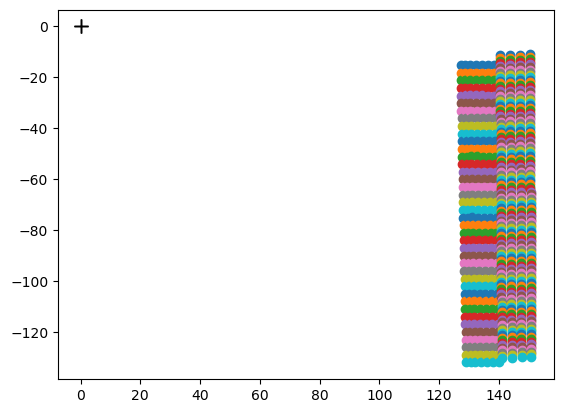

In [71]:
# Parse the XML file
tree = etree.parse('/media/mirko/Volume/GITHUB/QuestDB/src/worlds/cadriano.world')
# Get the root element
root = tree.getroot()


files = ['/media/mirko/Volume/GITHUB/QuestDB/config/metadata/plant_vectors/PL-15.geojson',
         '/media/mirko/Volume/GITHUB/QuestDB/config/metadata/plant_vectors/PL-20.geojson',
         '/media/mirko/Volume/GITHUB/QuestDB/config/metadata/plant_vectors/PL-SP.geojson']


for json_file in files:

    with open(json_file, 'r') as file:
        data = json.load(file)['features']



    # Find the 'state' tag
    state = root.find('.//state')
    model = root.find('world')

    PosX, PosY = latlon_to_xy(LOCAL_MAP_CENTER_COORD, LOCAL_MAP_CENTER_COORD)
    plt.plot(PosX, PosY, 'k+', markersize=10)

    for Obj in data:

        lon, lat, desc, plantID = Obj['properties'].values()

        if desc != '1st_tree':

            PosX, PosY = latlon_to_xy(LOCAL_MAP_CENTER_COORD, (lat, lon))
            PosX, PosY = rotate_point(PosX, PosY, 30)

            # print(PosX, PosY)

            plt.plot(PosX, PosY, 'o')

            # Create a new XML model string
            new_state_model_string = create_xml_state_model(plantID, PosX, PosY, 0, 0)
            
            # Parse the new XML model string into an Element
            new_state_model_element = etree.fromstring(new_state_model_string)
        
            # Add the new model element to the root element
            state.append(new_state_model_element)

            # new model
            model_str = create_xml_planar_tree_model(plantID)
            model_element = etree.fromstring(model_str)
            # print(model_str)

            model.append(model_element)

# Create an ElementTree from the root element
tree = etree.ElementTree(root)

# Write the modified XML back to a file
with open('automatic_world3.world', 'wb') as f:
    tree.write(f, pretty_print=True, encoding='utf-8', xml_declaration=True)

plt.show()